In [1]:
!pip install sklearn

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [66]:
import os
import h5py
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf
from tensorflow import keras
import gc
from sys import getsizeof
import datetime
import random
import math
from sklearn.metrics import classification_report, confusion_matrix

In [67]:
GB = 1
gpus = tf.config.experimental.list_physical_devices('GPU')
#The variable GB is the memory size you want to use.
config = [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=(1500*GB))]
if gpus:
  # Restrict TensorFlow to only allocate 1*X GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(gpus[0], config)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)
np.set_printoptions(threshold=40*40)


In [68]:
def load_data(res, source_labels, dataset='train', size=1., verbosity = False):
    data = np.zeros((0, res, res, res))
    labels = []
    for i, label in enumerate(source_labels):
        filename = './output/' + label + '/output-' + dataset + '-' + str(res) + '.h5'
        file = h5py.File(filename, 'r')
        tensor_len = len(file['tensor'])
        picked_ids = random.sample(range(tensor_len), math.ceil(tensor_len * size))
        if verbosity:
            print(filename)
            print('Picking ' + str(math.ceil(tensor_len * size)) + ' from ' + str(len(file['tensor'])) )
        data = np.concatenate((data, [file['tensor'][index] for index in picked_ids]))
        labels = np.concatenate((labels, np.full(len(picked_ids), i)))
        file.close()
        gc.collect()
    rng_state = np.random.get_state()
    np.random.shuffle(data)
    np.random.set_state(rng_state)
    np.random.shuffle(labels)
    return (data, labels)


In [69]:
def prepare_model(res, num_classes, verbosity = 0):
    model = keras.Sequential([
        keras.layers.Flatten(input_shape=(res, res, res)),
        keras.layers.Dense(res*2, activation='relu'),
        keras.layers.Dense(res/2, activation='sigmoid'),
        keras.layers.Dropout(.2, input_shape=(2,)),
        keras.layers.Dense(num_classes, activation='softmax')
    ])

    learning_rate = 0.0001

    model.compile(optimizer=keras.optimizers.Adam(lr=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    if (verbosity == 1):
        print(model.summary())
    return model
def prepare_data(data, num_classes, res):
    return data
model_type = 'dense'
prepare_model(24, 20, 1)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 13824)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 48)                663600    
_________________________________________________________________
dense_8 (Dense)              (None, 12)                588       
_________________________________________________________________
dropout_1 (Dropout)          (None, 12)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 20)                260       
Total params: 664,448
Trainable params: 664,448
Non-trainable params: 0
_________________________________________________________________
None


In [78]:
def prepare_model(res, num_classes, verbosity = 0):
    model = keras.Sequential([
        keras.layers.Conv3D(
                1, 
                kernel_size=(2),
                strides=(1),
                activation='relu', 
                kernel_initializer='he_uniform', 
                data_format="channels_last",
                input_shape=(res, res, res, 1)
            ),        
        keras.layers.Conv3D(
                1, 
                kernel_size=(2),
                strides=(1),
                activation='relu', 
                kernel_initializer='he_uniform'
            ),        
        #keras.layers.Conv3D(
        #        res, 
        #        kernel_size=(2),
        #        activation='relu', 
        #        kernel_initializer='he_uniform'
        #    ),        
   
        #keras.layers.MaxPooling3D(pool_size=(2, 2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dense(res/2, activation='relu'),
        keras.layers.Dense(num_classes, activation='softmax')
    ])

    learning_rate = 0.0001

    model.compile(optimizer=keras.optimizers.Adam(lr=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    if (verbosity == 1):
        print(model.summary())
    return model
def prepare_data(data, num_classes, res):
    return data.reshape(len(data), res, res, res, 1)
model_type = 'conv3d'
prepare_model(24, 10, 1)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_6 (Conv3D)            (None, 23, 23, 23, 1)     9         
_________________________________________________________________
conv3d_7 (Conv3D)            (None, 22, 22, 22, 1)     9         
_________________________________________________________________
flatten_6 (Flatten)          (None, 10648)             0         
_________________________________________________________________
dense_15 (Dense)             (None, 12)                127788    
_________________________________________________________________
dense_16 (Dense)             (None, 10)                130       
Total params: 127,936
Trainable params: 127,936
Non-trainable params: 0
_________________________________________________________________
None


In [79]:
def train(model, training, training_labels, res, num_classes, verbosity = 0):
    log_dir = "logs/fit/" + str(res) + '-' + str(num_classes) + '-' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    if verbosity == 1:
        print("Log file " + log_dir)
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    validation_split = 0.1
    epochs = 2 * num_classes
    
#    model.fit(
#        keras.utils.to_categorical(training, num_clases), 
#        training_labels, 
#        epochs=epochs)
    
    model.fit(
        prepare_data(training, num_classes, res), 
        training_labels, 
        epochs=epochs,
        verbose=verbosity,
        callbacks=[tensorboard_callback],
        validation_split=validation_split
    )

In [80]:
#Confusion Matrix and Classification Report
def print_confusion_matrix(test, test_labels, base_labels, res):
    Y_pred = model.predict_generator(prepare_data(test, len(base_labels), res), len(test))
    y_pred = np.argmax(Y_pred, axis=1)
    print('Confusion Matrix')
    print(confusion_matrix(test_labels, y_pred))
    print('Classification Report')
    print(classification_report(test_labels, y_pred, target_names=base_labels))

In [81]:
#base_labels = ['bathtub', 'bed', 'chair', 'desk', 'dresser', 'monitor', 'night_stand', 'sofa', 'table', 'toilet']
all_labels = ['airplane', 'bathtub', 'bed', 'bench', 'bookshelf', 'bottle', 'bowl', 'car', 'chair', 'cone', 
                 'cup', 'curtain', 'desk', 'door', 'dresser', 'flower_pot', 'glass_box', 'guitar','keyboard', 'lamp',
                 'laptop', 'mantel', 'monitor', 'night_stand', 'person', 'piano', 'plant', 
                 'radio', 'range_hood', 'sink', 'sofa', 'stairs', 'stool', 'table', 'tent', 'toilet', 'tv_stand', 
                 'vase', 'wardrobe', 'xbox']
#num_classes = len(base_labels)

In [73]:
res = 24
training, training_labels = load_data(res, all_labels, 'train', 1, False)


In [11]:
training[0].shape

(24, 24, 24)

In [82]:
subclases = [40]
resolutions = [24]#, 32]#, 48]

for j, num_classes in enumerate(subclases):
    base_labels = all_labels[:num_classes]
    for i,res in enumerate(resolutions):
        training, training_labels = load_data(res, base_labels, 'train', 1, False)
        model = prepare_model(res, num_classes, 1)
        model_name = 'models/' + model_type + '-' + str(num_classes) + '-' + str(res) + '.h5'
        train(model, training, training_labels, res, num_classes, 2)
        model.save(model_name)
        test, test_labels = load_data(res, base_labels, 'test', 1.0, False)
        test_loss, test_acc = model.evaluate(
            prepare_data(test, num_classes, res),  
            test_labels, 
            verbose=2
        )
        print('\nTest accuracy for ' + str(num_classes) + ' classes width res ' + str(res) + ':', test_acc)
        print_confusion_matrix(test, test_labels, base_labels, res)
        gc.collect()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_8 (Conv3D)            (None, 23, 23, 23, 1)     9         
_________________________________________________________________
conv3d_9 (Conv3D)            (None, 22, 22, 22, 1)     9         
_________________________________________________________________
flatten_7 (Flatten)          (None, 10648)             0         
_________________________________________________________________
dense_17 (Dense)             (None, 12)                127788    
_________________________________________________________________
dense_18 (Dense)             (None, 40)                520       
Total params: 128,326
Trainable params: 128,326
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/80
277/277 - 38s - loss: 3.4198 - accuracy: 0.1373 - val_loss: 3.1544 - val_accuracy: 0.2020
Epoch 2/

Epoch 72/80
277/277 - 31s - loss: 0.2012 - accuracy: 0.9491 - val_loss: 2.7102 - val_accuracy: 0.6822
Epoch 73/80
277/277 - 33s - loss: 0.1985 - accuracy: 0.9503 - val_loss: 2.7099 - val_accuracy: 0.6731
Epoch 74/80
277/277 - 32s - loss: 0.1959 - accuracy: 0.9525 - val_loss: 2.7904 - val_accuracy: 0.6701
Epoch 75/80
277/277 - 32s - loss: 0.1912 - accuracy: 0.9511 - val_loss: 2.8009 - val_accuracy: 0.6690
Epoch 76/80
277/277 - 31s - loss: 0.1885 - accuracy: 0.9513 - val_loss: 2.8450 - val_accuracy: 0.6751
Epoch 77/80
277/277 - 34s - loss: 0.1861 - accuracy: 0.9530 - val_loss: 2.8600 - val_accuracy: 0.6761
Epoch 78/80
277/277 - 31s - loss: 0.1839 - accuracy: 0.9536 - val_loss: 2.8482 - val_accuracy: 0.6701
Epoch 79/80
277/277 - 31s - loss: 0.1816 - accuracy: 0.9541 - val_loss: 2.8999 - val_accuracy: 0.6721
Epoch 80/80
277/277 - 31s - loss: 0.1797 - accuracy: 0.9542 - val_loss: 2.9634 - val_accuracy: 0.6731
78/78 - 7s - loss: 3.1840 - accuracy: 0.6337

Test accuracy for 40 classes width r

In [75]:
#num_classes = 20
#res = 24
base_labels = all_labels[:num_classes]
test, test_labels = load_data(res, base_labels, 'test', 1.0, False)


In [83]:
test_loss, test_acc = model.evaluate(
            prepare_data(test, num_classes, res),  
            test_labels, 
            verbose=2
        )
print('\nTest accuracy for ' + str(num_classes) + ' classes width res ' + str(res) + ':', test_acc)
print_confusion_matrix(test, test_labels, base_labels, res)

78/78 - 5s - loss: 3.1840 - accuracy: 0.6337

Test accuracy for 40 classes width res 24: 0.6337115168571472
Confusion Matrix
[[90  0  1  0  0  0  0  4  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0
   0  1  0  0  0  0  0  0  0  0  0  0  0  3  0  0]
 [ 2 31  5  0  0  0  2  1  0  0  0  0  1  0  1  0  0  1  0  0  0  0  0  0
   0  0  0  1  0  0  1  0  0  3  1  0  0  0  0  0]
 [ 2  1 81  0  0  0  0  1  2  0  0  0  0  0  0  0  1  0  0  0  1  0  0  0
   0  2  0  0  0  1  1  0  0  0  2  1  4  0  0  0]
 [ 0  0  0  9  0  0  0  1  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  1
   0  1  0  0  0  0  1  0  0  1  0  0  5  0  0  0]
 [ 0  0  0  1 73  2  0  0  1  0  0  1  0  3  0  2  1  0  0  0  0  2  0  0
   0  1  0  0  0  0  0  0  1  0  0  0  1  2  5  4]
 [ 0  0  0  0  1 60  1  0  1  3  0  0  0  0  0  0  0  0  0  0  2  0  0  0
   0  0  4  0  0  0  0  1  0  0  0  0  0 26  1  0]
 [ 1  0  0  0  0  0  7  0  0  0  0  0  0  0  0  0  1  1  0  0  2  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  4  4  0  0]


In [15]:
base_labels = all_labels
res=24
training, training_labels = load_data(res, base_labels, 'train', 1, False)

In [16]:
for i in range(40):
    print(str(i) + ':' + str(len(training_labels[training_labels == i])))


0:626
1:106
2:515
3:173
4:572
5:335
6:64
7:197
8:889
9:167
10:79
11:138
12:200
13:109
14:200
15:149
16:171
17:155
18:145
19:124
20:149
21:284
22:465
23:200
24:88
25:231
26:240
27:104
28:115
29:128
30:680
31:124
32:90
33:392
34:163
35:344
36:267
37:475
38:87
39:103


In [17]:
model = keras.models.load_model('models/dense-20-24')


OSError: SavedModel file does not exist at: models/dense-20-24/{saved_model.pbtxt|saved_model.pb}

In [33]:
def draw(img, expected = '', predicted = ''):
    fig = plt.figure(figsize=[10,10])
    ax = fig.gca(projection='3d')
    cube1 = (img[:,:,:] >= 1)
    ax.voxels(cube1, facecolors="blue")
    #plt.title('Expected: {}\n Predicted: {}'.format(expected, predicted), y=-0.01)
    plt.title('Model: {}'.format(expected), y=-0.01)
    plt.show()

In [ ]:
if not len(test):
    test, test_labels = load_data(dim, base_labels, 'test', 100)
test_loss, test_acc = model.evaluate(test,  test_labels, verbose=2)
p = model.predict(test)
print('\nTest accuracy:', test_acc)

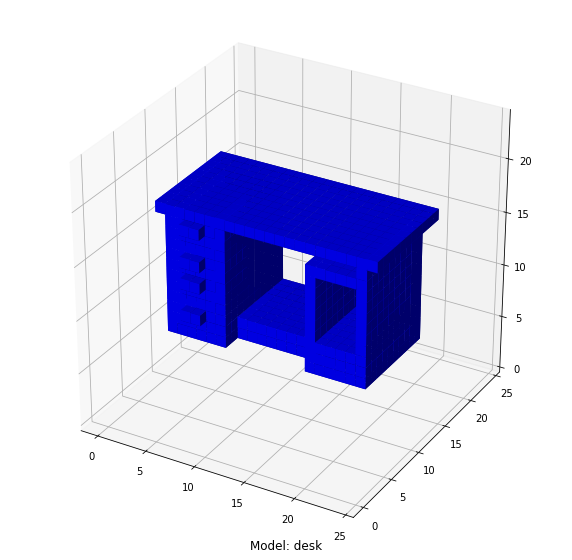

desk


1083

In [65]:
index = random.randint(0, len(test))

#predicted_index = np.argmax(p[index])
#expected = base_labels[int(test_labels[index])]
#predicted = base_labels[predicted_index]
draw(test[index], all_labels[int(test_labels[index])], '')
print(all_labels[int(test_labels[index])])
index

In [ ]:
num_classes = 3
base_labels = all_labels[:num_classes]
num_classes = num_classes
res = 24
training, training_labels = load_data(res, base_labels, 'train', 1, True)


In [ ]:
print(len(training))
model = prepare_model(res, num_classes, 1)
train(model, training, training_labels, res, num_classes, 0)


In [ ]:
print(base_labels)
test, test_labels = load_data(res, base_labels, 'test', 1.0, True)
print(len(test))
test_loss, test_acc = model.evaluate(
    test,  
    test_labels, 
    verbose=2
)


In [ ]:
p = model.predict(test)
for index in range(len(p)):
    predicted_index = np.argmax(p[index])
    expected = base_labels[int(test_labels[index])]
    predicted = base_labels[predicted_index]
    if expected != predicted:
        draw(test[index], expected, predicted)
